# Simulated binary tree data

Here, we introduce a basic Ocelli pipeline for analyzing multi-view datasets.

Remark: We recommend using 3D interactive plots when visualizing data. Unfortunately, these plots are not compatible with the ReadTheDocs online documentation, so here we show only static 2D plots.

In [1]:
import ocelli as oci

Apart from importing Ocelli, we change matplotlib setting to display larger plots.

In [2]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 200

SEED=17

## Load the data

Ocelli is integrated with the annotated data structure [AnnData](https://anndata.readthedocs.io/en/latest/), which can be stored as a .h5ad file. Such files can be loaded using [scanpy](https://scanpy.readthedocs.io/en/stable/).

In [3]:
import scanpy as scp

adata = scp.read_h5ad('../../../data/binary-tree-dataset.h5ad')
adata

AnnData object with n_obs × n_vars = 6000 × 1
    obs: 'celltype', 'pseudotime'
    uns: 'modalities'
    obsm: 'modality0', 'modality1', 'modality2'

Now, we visualize 3D views by projecting them onto a plane.

The first view:

(<Figure size 1280x960 with 1 Axes>, <AxesSubplot:>)

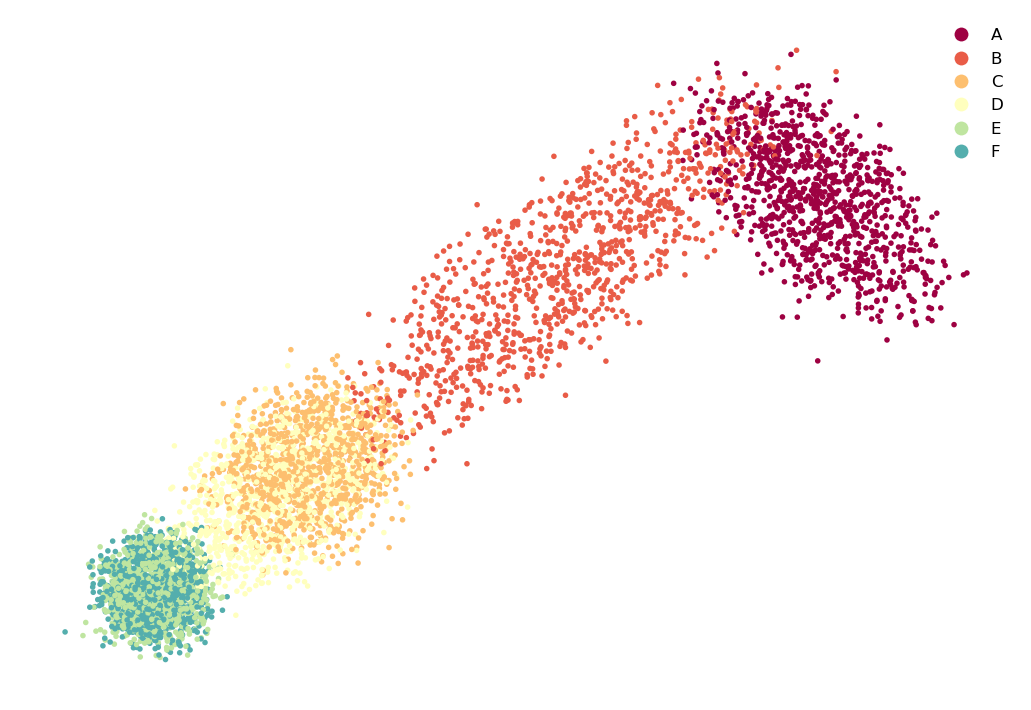

In [4]:
oci.tl.project_2d(adata, x3d_key='modality0', output_key='modality0_proj', alpha=30, beta=0)
oci.pl.scatter(adata, x_key='modality0_proj', color_key='celltype', marker_size=1)

The second view:

(<Figure size 1280x960 with 1 Axes>, <AxesSubplot:>)

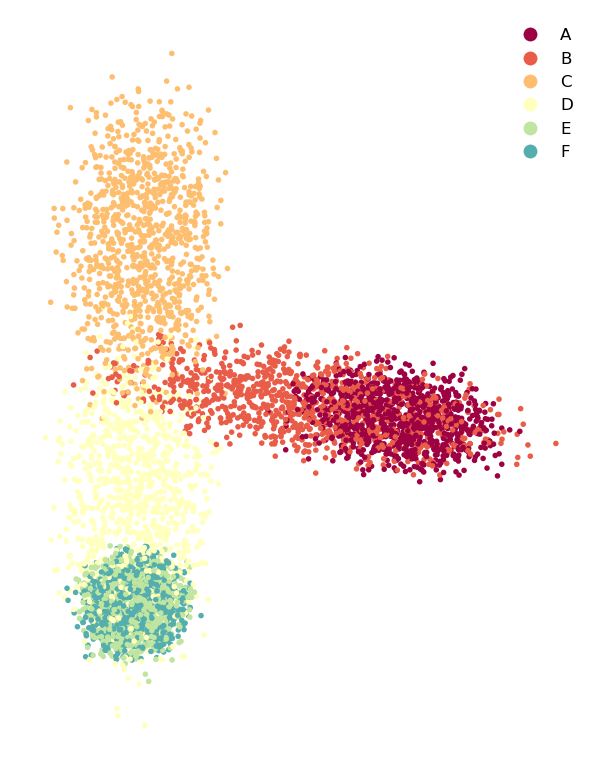

In [5]:
oci.tl.project_2d(adata, x3d_key='modality1', output_key='modality1_proj', alpha=--60, beta=60)
oci.pl.scatter(adata, x_key='modality1_proj', color_key='celltype', marker_size=1)

The third view:

(<Figure size 1280x960 with 1 Axes>, <AxesSubplot:>)

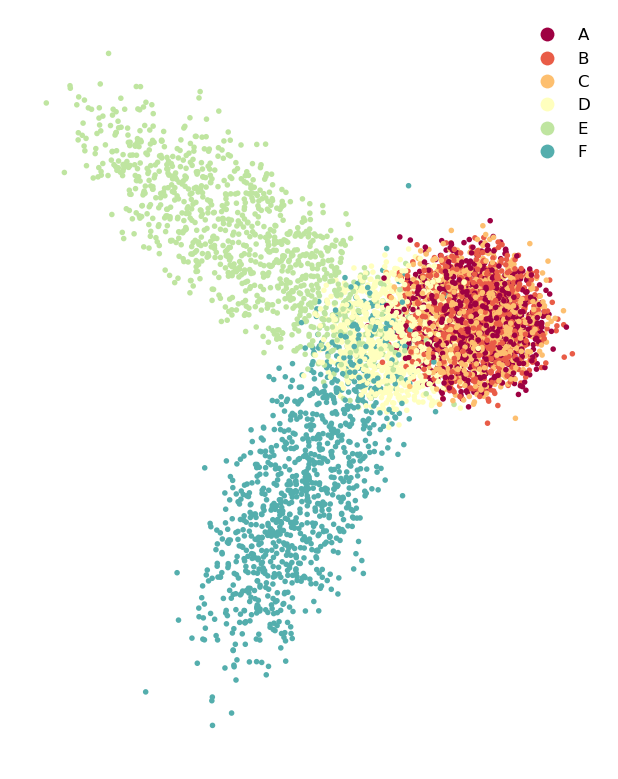

In [6]:
oci.tl.project_2d(adata, x3d_key='modality2', output_key='modality2_proj', alpha=30, beta=30)
oci.pl.scatter(adata, x_key='modality2_proj', color_key='celltype', marker_size=1)

As seen above, the first view differentiates well between celltypes A-B, the second view between celltypes C-D, and the third view between celltypes E-F. Multi-view diffusion maps' goal is to learn it in unsupervised fashion. 

To begin the analysis, we define which x.obsm keys store views. Ocelli remembers and utilizes this information throughout the whole pipeline.

Then, we calculate nearest neighbors and multi-view weights. These weights quantify how do views promote the developmental process for each cell.

## Calculate Multimodal Diffusion Maps components

In [7]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.weights(adata, random_state=SEED, verbose=True)

20 nearest neighbors calculated.


2022-09-26 22:41:34,952	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal cell-specific weights estimated.


Weights are saved in x.obsm as a pandas.DataFrame of shape (6000, 3). Ocelli provides a tool for visualizing weights distributions.

In [8]:
adata.obsm['weights']

,modality0,modality1,modality2
0,0.973592,0.025576,0.000832
1,0.989186,0.008797,0.002017
2,0.992478,0.006181,0.001341
3,0.967995,0.030422,0.001583
4,0.993608,0.004865,0.001527
...,...,...,...
5995,0.000107,0.000101,0.999793
5996,0.000115,0.000101,0.999784
5997,0.000117,0.000101,0.999782
5998,0.000159,0.000095,0.999746


(<Figure size 1280x960 with 18 Axes>,
 array([[<AxesSubplot:title={'center':'A'}, ylabel='modality0'>,
         <AxesSubplot:title={'center':'B'}>,
         <AxesSubplot:title={'center':'C'}>,
         <AxesSubplot:title={'center':'D'}>,
         <AxesSubplot:title={'center':'E'}>,
         <AxesSubplot:title={'center':'F'}>],
        [<AxesSubplot:ylabel='modality1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='modality2'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

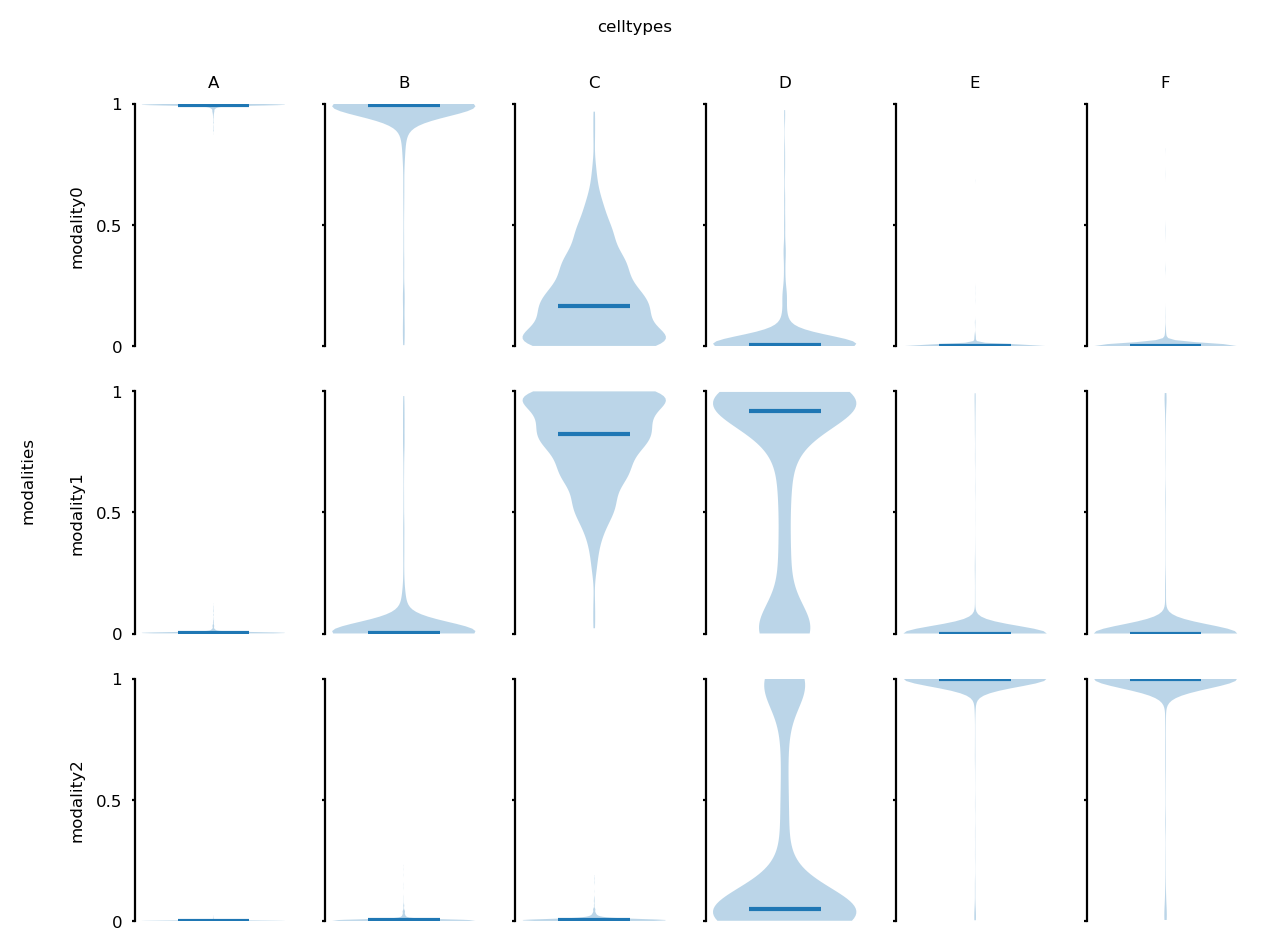

In [9]:
oci.pl.weights(adata)

As seen above, MVDM correctly detects which views differentiate which cells. The multi-view weights are then used to calculate the multi-view diffusion maps embedding. In this case, it is 10-dimensional.

In [11]:
oci.tl.MDM(adata, n_components=10, unimodal_norm=False, verbose=True, random_state=SEED)
adata

Unimodal Markov chain calculated (1/3)
Unimodal Markov chain calculated (2/3)
Unimodal Markov chain calculated (3/3)
Multimodal Markov chain calculated
Eigendecomposition finished.
10 Multimodal Diffusion Maps components calculated.


AnnData object with n_obs × n_vars = 6000 × 1
    obs: 'celltype', 'pseudotime'
    uns: 'modalities', 'neighbors', 'distances', 'epsilons'
    obsm: 'modality0', 'modality1', 'modality2', 'modality0_proj', 'modality1_proj', 'modality2_proj', 'weights', 'X_mdm'

## Visualize the data

Now, the nearest neighbors graph is constructed by performing the nearest neighbors search in the multi-view diffusion maps space.

In [12]:
oci.pp.neighbors(adata, modalities=['X_mdm'], neighbors_key='neighbors_mdm', n_neighbors=30, verbose=True)
oci.tl.nn_graph(adata, n=30, neighbors_key='neighbors_mdm', verbose=True)

30 nearest neighbors calculated.
Nearest neighbors-based graph constructed.


Graph is visualized using the [ForceAtlas2](https://github.com/klarman-cell-observatory/forceatlas2) algorithm.

In [13]:
oci.tl.FA2(adata, n_components=2, n_steps=5000, random_state=SEED, output_key='X_fa2')

Sep 26, 2022 10:42:23 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Sep 26, 2022 10:42:25 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 6,000 (6,000 added)
Sep 26, 2022 10:42:25 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 180,000 (108,678 added)


*************************25%
********

*****************50%
*************************75%
*************************100%
Time = 80.295s


The 2-dimensional embedding is saved to x.obsm[x_fa2].

Plots can be static (showed here) or interactive. 
They can be colored using any metadata from x.obs. 
For static plots, color schemes can be changed by passing the name of any [built-in matplotlib colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html), or a custom colormap object.

Cell types:

(<Figure size 1280x960 with 1 Axes>, <AxesSubplot:>)

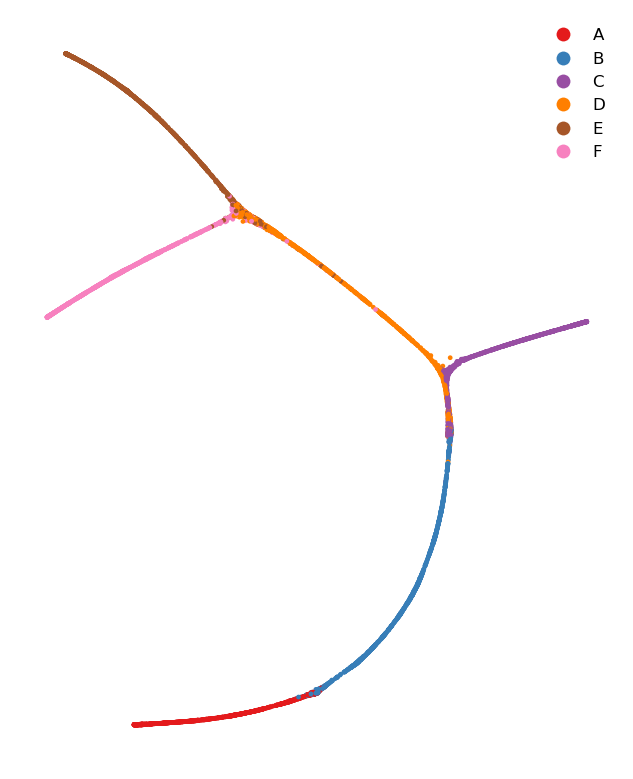

In [14]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='celltype', cmap='Set1', marker_size=0.5)

Cell development pseudotime:

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

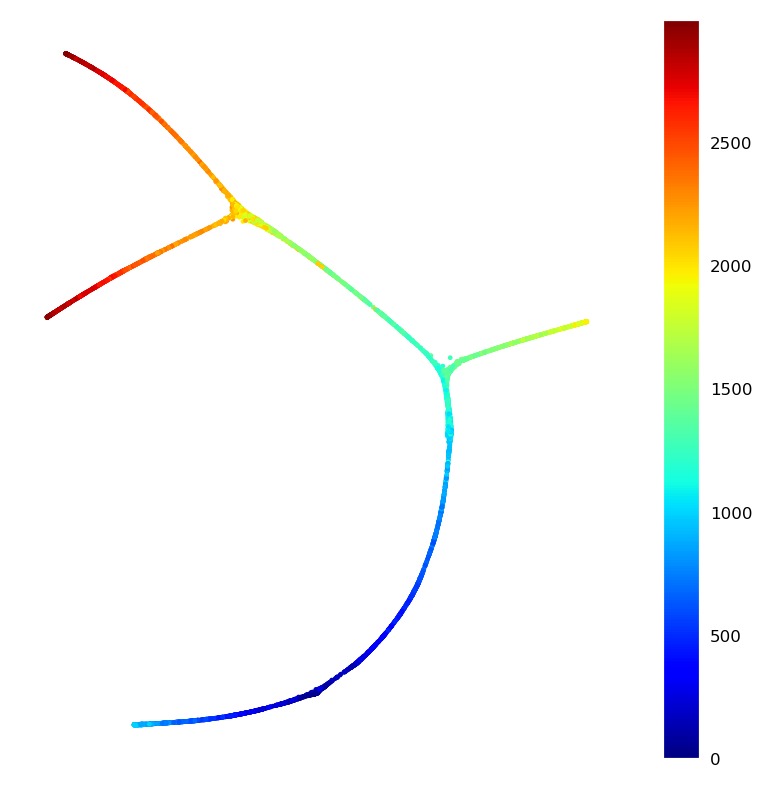

In [15]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='pseudotime', cmap='jet', marker_size=0.5)

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

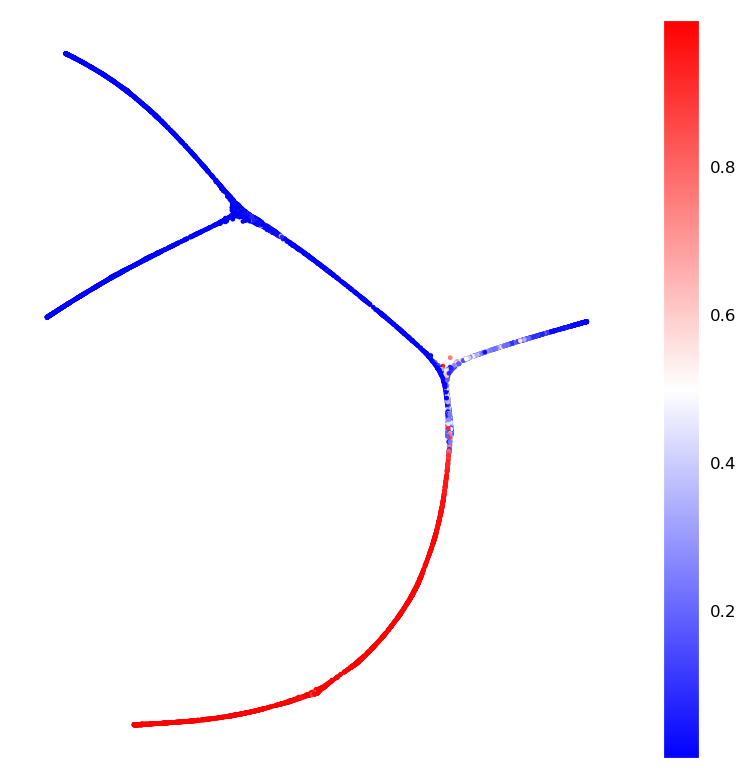

In [16]:
adata.obs['w_m0'] = list(adata.obsm['weights']['modality0'])
oci.pl.scatter(adata, x_key='X_fa2', color_key='w_m0', cmap='bwr', marker_size=0.5)

The second view's weights:

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

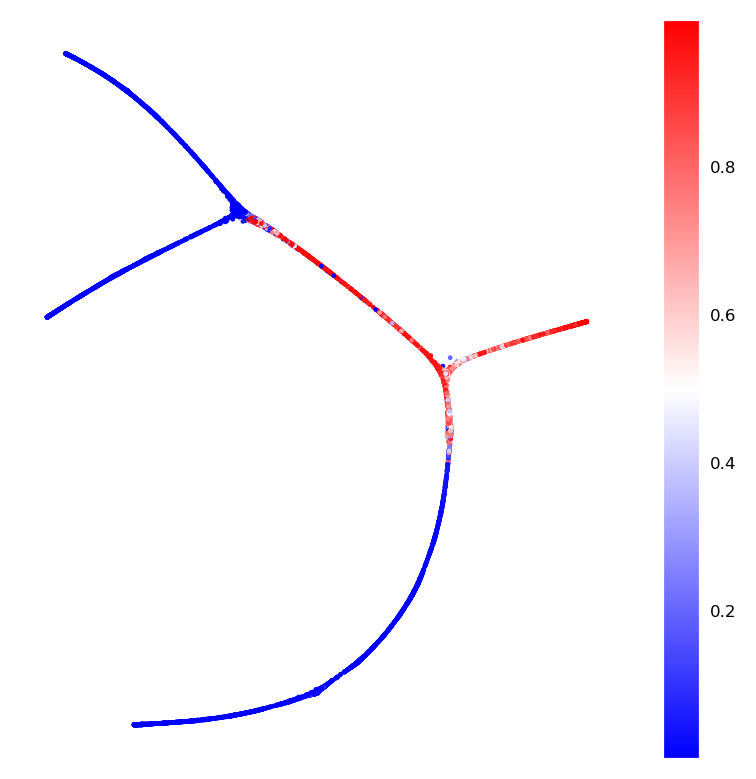

In [17]:
adata.obs['w_m1'] = list(adata.obsm['weights']['modality1'])
oci.pl.scatter(adata, x_key='X_fa2', color_key='w_m1', cmap='bwr', marker_size=0.5)

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

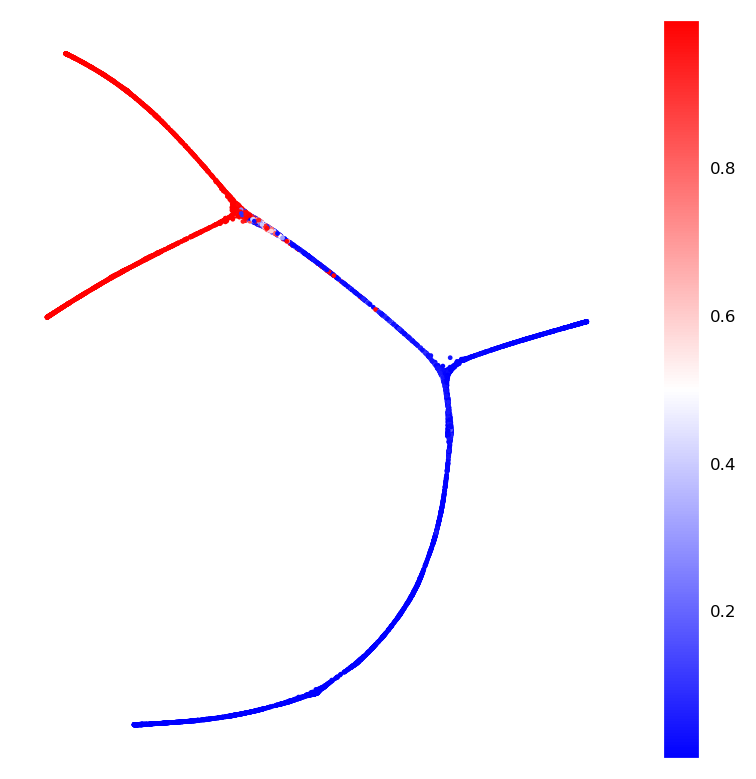

In [18]:
adata.obs['w_m2'] = list(adata.obsm['weights']['modality2'])
oci.pl.scatter(adata, x_key='X_fa2', color_key='w_m2', cmap='bwr', marker_size=0.5)